# 文件分類

**Author:** 黃天原  
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：股市、運動、兩岸、全球

* 分析主題：將聯合新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

Text(0.5, 1.0, '聲量圖')

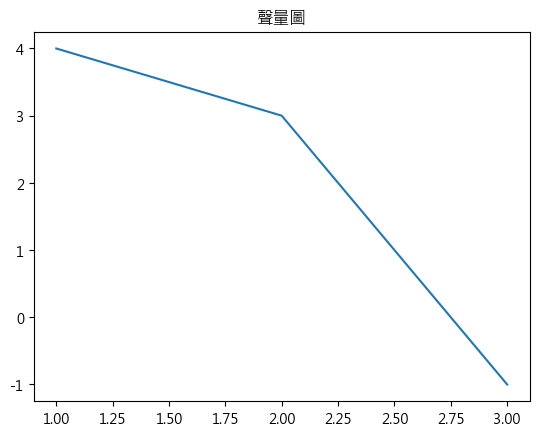

In [2]:
# https://zhuanlan.zhihu.com/p/566430362
# from matplotlib import font_manager
# font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`udn_news_202402.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：股市、全球、運動、兩岸
- 時間範圍：2024/02/01 ~ 2024/02/29
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [4]:
udn = pd.read_csv("raw_data/group3_train.csv")  # 匯資料
udn.head(3)

,ㄧㄠ,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平,3/21/2024 9:56,運動,https://udn.com/news/story/11247/7845714,曾經是形影不離的戰友，大谷翔平與水原一平如今因金錢關係成為陌生人，大谷翔平的個人社群也解除對...,UDN
1,2,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」,3/21/2024 10:28,運動,https://udn.com/news/story/11247/7845808,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭，已遭洛杉磯道奇解雇。大谷轉...,UDN
2,3,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊,3/21/2024 10:36,運動,https://udn.com/news/story/11247/7845856,美國職棒大聯盟（MLB）球星大谷翔平的隨行翻譯水原一平，因涉嫌竊取大谷至少450萬美元進行非...,UDN


In [5]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8165
date range: ('2/19/2024 0:46', '3/9/2024 9:39')
category: 
股市    3564
兩岸    2548
運動    2053
Name: artCatagory, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [6]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,ㄧㄠ,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,曾說不是朋友成真大谷翔平解除追蹤水原一平,3/21/2024 9:56,運動,https://udn.com/news/story/11247/7845714,曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係成為陌生人大谷翔平的個人社群也解除對水原...,UDN
1,2,水原一平涉賭被解僱日本網友震驚巨大背叛,3/21/2024 10:28,運動,https://udn.com/news/story/11247/7845808,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭已遭洛杉磯道奇解雇大谷轉戰美...,UDN
2,3,偷大谷翔平的錢還賭債水原一平被球迷灌爆你搞屁啊,3/21/2024 10:36,運動,https://udn.com/news/story/11247/7845856,美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因涉嫌竊取大谷至少萬美元進行非法賭博遭到道奇隊開...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [7]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,曾說不是朋友成真大谷翔平解除追蹤水原一平曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係...,https://udn.com/news/story/11247/7845714,運動
1,水原一平涉賭被解僱日本網友震驚巨大背叛日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美...,https://udn.com/news/story/11247/7845808,運動
2,偷大谷翔平的錢還賭債水原一平被球迷灌爆你搞屁啊美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因...,https://udn.com/news/story/11247/7845856,運動
3,國內球評看水原一平醜聞形容比大谷結婚令人震撼道奇教士隊在南韓首爾進行新球季第場比賽前大谷翔平...,https://udn.com/news/story/11247/7845919,運動
4,大谷翔平恐受牽連水原一平稱他曾代為轉帳償還賭債後才改口美國職棒大聯盟明星大谷翔平的翻譯水原一...,https://udn.com/news/story/11247/7846177,運動


In [89]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 8165


### 2.2 斷詞

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [10]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week7\dict\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.ub5262a87d759ee9d0e154d1fa206fecd.cache
Loading model cost 0.733 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,曾說不是朋友成真大谷翔平解除追蹤水原一平曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係...,https://udn.com/news/story/11247/7845714,運動,朋友 大谷 翔平 解除 追蹤 水原 一平 曾經 形影不離 戰友 大谷 翔平 水原 一平 金錢...
1,水原一平涉賭被解僱日本網友震驚巨大背叛日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美...,https://udn.com/news/story/11247/7845808,運動,水原 一平 涉賭 解僱 日本 網友 震驚 巨大 背叛 日本 棒球 明星 大谷 翔平 翻譯 水...
2,偷大谷翔平的錢還賭債水原一平被球迷灌爆你搞屁啊美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因...,https://udn.com/news/story/11247/7845856,運動,大谷 翔平 錢還 賭債 水原 一平 球迷 灌爆 美國 職棒 聯盟 球星 大谷 翔平 隨行 翻...
3,國內球評看水原一平醜聞形容比大谷結婚令人震撼道奇教士隊在南韓首爾進行新球季第場比賽前大谷翔平...,https://udn.com/news/story/11247/7845919,運動,國內 球評 水原 一平 醜聞 形容 大谷 結婚 令人 震撼 道奇 教士 南韓 首爾 進行 球...
4,大谷翔平恐受牽連水原一平稱他曾代為轉帳償還賭債後才改口美國職棒大聯盟明星大谷翔平的翻譯水原一...,https://udn.com/news/story/11247/7846177,運動,大谷 翔平 恐受 牽連 水原 一平稱 曾代為 轉帳 償還 賭債 改口 美國 職棒 聯盟 明星...


### 2.3 資料集基本檢視

檢視資料內容

In [93]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 8165
category: 
artCatagory
股市    3564
兩岸    2548
運動    2053
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [98]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1484    林俊吉 攻下 分率 夢想家 勇奪 連勝 台灣 職籃 福爾摩沙 夢想家 今天 本土 後衛 林俊...
5725    狼來了 大使 盧沙野談 外交 中國 韜光養晦 外媒 形容 外交 戰狼 中國 大陸 駐法 大使...
7066    下個 破產 造車 勢力 高合 汽車 停工 停產 半年 鎖定 高端 車款 大陸 造車 勢力 高...
5095    藥局 股股 諾貝 掛牌 首日 股價 飆漲 二成 諾貝 今日 每股 上櫃 早盤 股價 飆高 來...
5155    興櫃 美麗 酒店 重訊 公布 股票 自月 日起 暫停 交易 興櫃 公司 美麗 酒店 因有 重...
Name: words, dtype: object
1484    運動
5725    兩岸
7066    兩岸
5095    股市
5155    股市
Name: artCatagory, dtype: object


In [99]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
股市    43.649724
兩岸    31.206369
運動    25.143907
Name: proportion, dtype: float64

train percentage :
artCatagory
股市    43.517060
兩岸    31.321085
運動    25.161855
Name: proportion, dtype: float64

test percentage :
artCatagory
股市    43.959184
兩岸    30.938776
運動    25.102041
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [100]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [101]:
X_train.head()

1484    林俊吉 攻下 分率 夢想家 勇奪 連勝 台灣 職籃 福爾摩沙 夢想家 今天 本土 後衛 林俊...
5725    狼來了 大使 盧沙野談 外交 中國 韜光養晦 外媒 形容 外交 戰狼 中國 大陸 駐法 大使...
7066    下個 破產 造車 勢力 高合 汽車 停工 停產 半年 鎖定 高端 車款 大陸 造車 勢力 高...
5095    藥局 股股 諾貝 掛牌 首日 股價 飆漲 二成 諾貝 今日 每股 上櫃 早盤 股價 飆高 來...
5155    興櫃 美麗 酒店 重訊 公布 股票 自月 日起 暫停 交易 興櫃 公司 美麗 酒店 因有 重...
Name: words, dtype: object

In [102]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<5715x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 321549 stored elements in Compressed Sparse Row format>

In [103]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [104]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一些' '一名' '一場' '一定' '一平' '一年' '一度' '一次' '一直' '一起']


In [105]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'攻下': 475, '連勝': 901, '台灣': 206, '今天': 69, '擊敗': 459, '桃園': 558, '拿下': 425, '近期': 886, '持續': 428, '龍頭': 999, '主場': 45, '主力': 44, '建立': 365, '領先': 978, '挹注': 434, '結束': 740, '形成': 376, '團隊': 249, '發揮': 673, '再度': 137, '並未': 33, '一度': 6, '尤其': 328, '終場': 736, '雙方': 961, '差距': 341, '總教練': 755, '得分': 382, '關鍵': 948, '最後': 531, '勝利': 170, '針對': 934, '布局': 347, '賽後': 868, '接受': 442, '訪問': 837, '透露': 890, '當時': 668, '希望': 348, '空間': 714, '球員': 643, '比較': 588, '情況': 390, '成功': 401, '指出': 430, '看到': 694, '努力': 167, '展現': 331, '防守': 949, '做好': 97, '相信': 690, '機會': 572, '很大': 379, '中國': 36, '大陸': 283, '委員': 290, '近日': 885, '回到': 238, '北京': 175, '出席': 141, '兩會': 127, '領域': 979, '最新': 533, '意見': 393, '方向': 503, '表示': 817, '能夠': 784, '過去': 908, '成為': 404, '旗下': 509, '媒體': 292, '上述': 23, '國家': 245, '擴大': 463, '國際': 248, '影響': 378, '積極': 710, '參與': 193, '全球': 120, '包含': 173, '關係': 946, '現在': 640, '強調': 374, '面對': 970, '壓力': 268, '觀察': 826, '發生': 677, '官員': 304, '之間': 52, '合作': 210, '地方': 251, '文化': 4

0

In [106]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(5715, 1000)
(2450, 1000)


In [107]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [108]:
clf.classes_

array(['兩岸', '股市', '運動'], dtype=object)

In [109]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['兩岸' '運動' '兩岸' '運動' '運動' '股市' '兩岸' '兩岸' '股市' '股市']


In [110]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(2450, 3)


array([9.99790701e-01, 2.08732282e-04, 5.66446109e-07])

In [111]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.99      0.98      0.98       758
          股市       0.99      0.99      0.99      1077
          運動       1.00      0.99      1.00       615

    accuracy                           0.99      2450
   macro avg       0.99      0.99      0.99      2450
weighted avg       0.99      0.99      0.99      2450



In [112]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 744,   13,    1],
       [   6, 1071,    0],
       [   5,    0,  610]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '兩岸'), Text(0, 1.5, '股市'), Text(0, 2.5, '運動')])

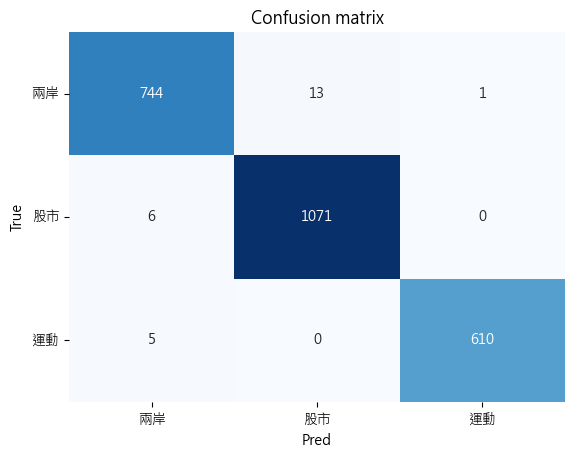

In [113]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [114]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0918026 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11605757, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11940435,
       0.1134764 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18206788,
       0.        , 0.        , 0.        , 0.        , 0.     

In [115]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.99      0.98      0.98       758
          股市       0.99      0.99      0.99      1077
          運動       1.00      0.99      0.99       615

    accuracy                           0.99      2450
   macro avg       0.99      0.99      0.99      2450
weighted avg       0.99      0.99      0.99      2450



效果一樣也是不錯，可能因為四個新聞版別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [116]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.05920672, 0.03939533, 0.05532527, 0.04298472, 0.04117775]),
 'score_time': array([0.00577545, 0.01502514, 0.01189971, 0.01500893, 0.01657915]),
 'test_f1_macro': array([0.98747721, 0.98892167, 0.99299335, 0.98721821, 0.98862703]),
 'test_precision_macro': array([0.98866481, 0.98851369, 0.99241565, 0.98710048, 0.98876076]),
 'test_recall_macro': array([0.98636213, 0.98938173, 0.99359284, 0.98735203, 0.98851347])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [117]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98      1790
          股市       0.99      0.99      0.99      2487
          運動       0.99      0.99      0.99      1438

    accuracy                           0.99      5715
   macro avg       0.99      0.99      0.99      5715
weighted avg       0.99      0.99      0.99      5715



## 4. 比較不同模型效果

In [118]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98      1790
          股市       0.99      0.99      0.99      2487
          運動       0.99      0.99      0.99      1438

    accuracy                           0.99      5715
   macro avg       0.99      0.99      0.99      5715
weighted avg       0.99      0.99      0.99      5715



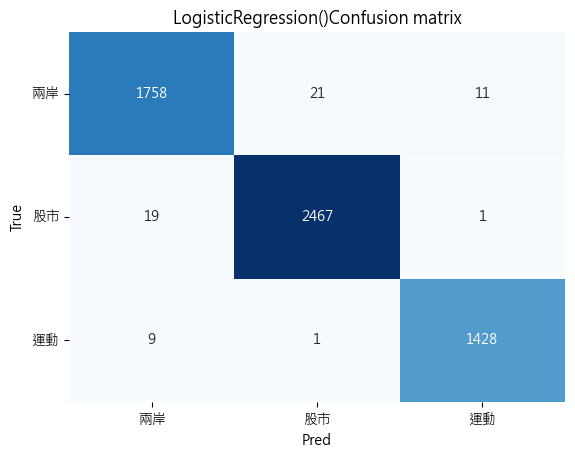

In [119]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98      1790
          股市       0.99      0.99      0.99      2487
          運動       0.99      0.99      0.99      1438

    accuracy                           0.99      5715
   macro avg       0.99      0.99      0.99      5715
weighted avg       0.99      0.99      0.99      5715

now training: clf_dtree
              precision    recall  f1-score   support

          兩岸       0.93      0.95      0.94      1790
          股市       0.96      0.96      0.96      2487
          運動       0.96      0.95      0.95      1438

    accuracy                           0.95      5715
   macro avg       0.95      0.95      0.95      5715
weighted avg       0.95      0.95      0.95      5715

now training: clf_svm
              precision    recall  f1-score   support

          兩岸       0.98      0.99      0.98      1790
          股市       0.99      0.99      0.99      2487
  

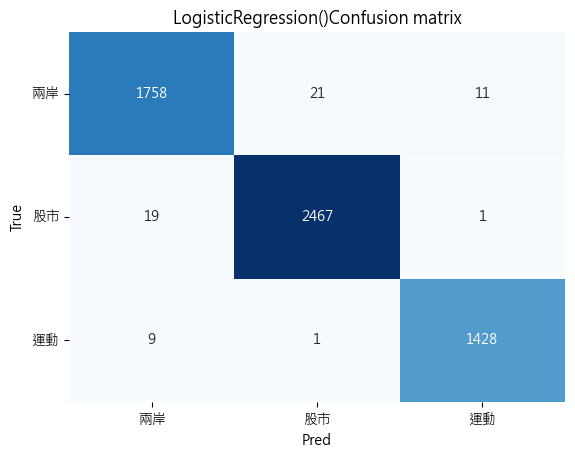

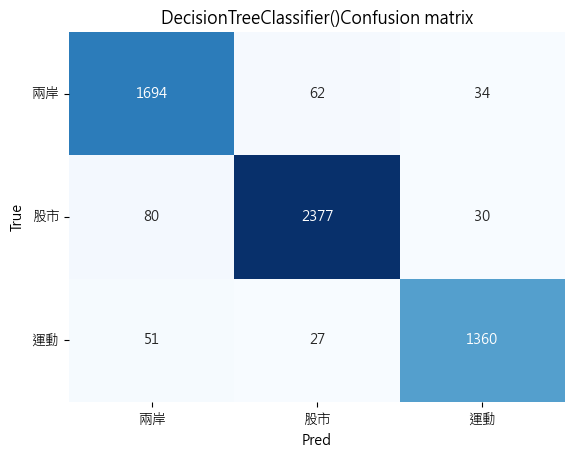

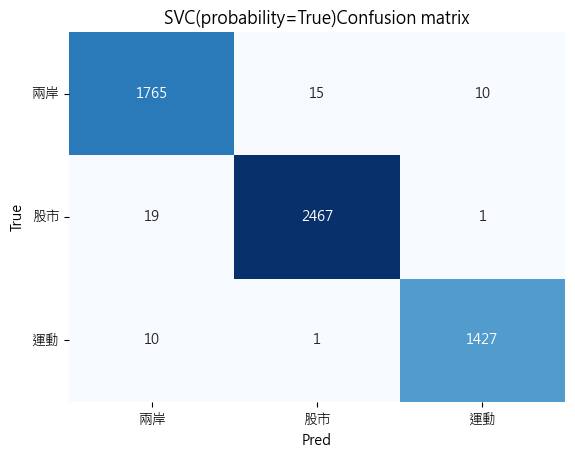

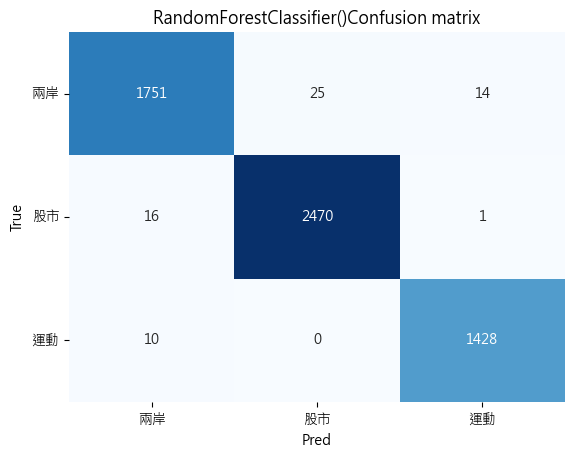

In [120]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [121]:
result_set['clf_logistic']

{'兩岸': {'precision': 0.9843225083986562,
  'recall': 0.982122905027933,
  'f1-score': 0.9832214765100671,
  'support': 1790.0},
 '股市': {'precision': 0.9911611088790679,
  'recall': 0.9919581825492562,
  'f1-score': 0.9915594855305466,
  'support': 2487.0},
 '運動': {'precision': 0.9916666666666667,
  'recall': 0.9930458970792768,
  'f1-score': 0.9923558026407228,
  'support': 1438.0},
 'accuracy': 0.98915135608049,
 'macro avg': {'precision': 0.9890500946481303,
  'recall': 0.989042328218822,
  'f1-score': 0.9890455882271122,
  'support': 5715.0},
 'weighted avg': {'precision': 0.9891463927353461,
  'recall': 0.98915135608049,
  'f1-score': 0.9891482988039979,
  'support': 5715.0}}

In [122]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9902012248468941,
 'macro avg': {'f1-score': 0.9900133539123009,
               'precision': 0.9899138914663993,
               'recall': 0.9901140629631778,
               'support': 5715.0},
 'weighted avg': {'f1-score': 0.9902039627308911,
                  'precision': 0.9902080288199221,
                  'recall': 0.9902012248468941,
                  'support': 5715.0},
 '兩岸': {'f1-score': 0.9849330357142857,
        'precision': 0.9838350055741361,
        'recall': 0.9860335195530726,
        'support': 1790.0},
 '股市': {'f1-score': 0.9927565392354125,
        'precision': 0.9935561820378574,
        'recall': 0.9919581825492562,
        'support': 2487.0},
 '運動': {'f1-score': 0.9923504867872045,
        'precision': 0.9923504867872045,
        'recall': 0.9923504867872045,
        'support': 1438.0}}


In [127]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.99      0.98      0.98       758
          股市       0.99      0.99      0.99      1077
          運動       0.99      0.99      0.99       615

    accuracy                           0.99      2450
   macro avg       0.99      0.99      0.99      2450
weighted avg       0.99      0.99      0.99      2450



In [129]:
model_set['clf_svm'].predict(vectorizer.transform(["長榮 00940 台積電"]).toarray())

array(['股市'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [137]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

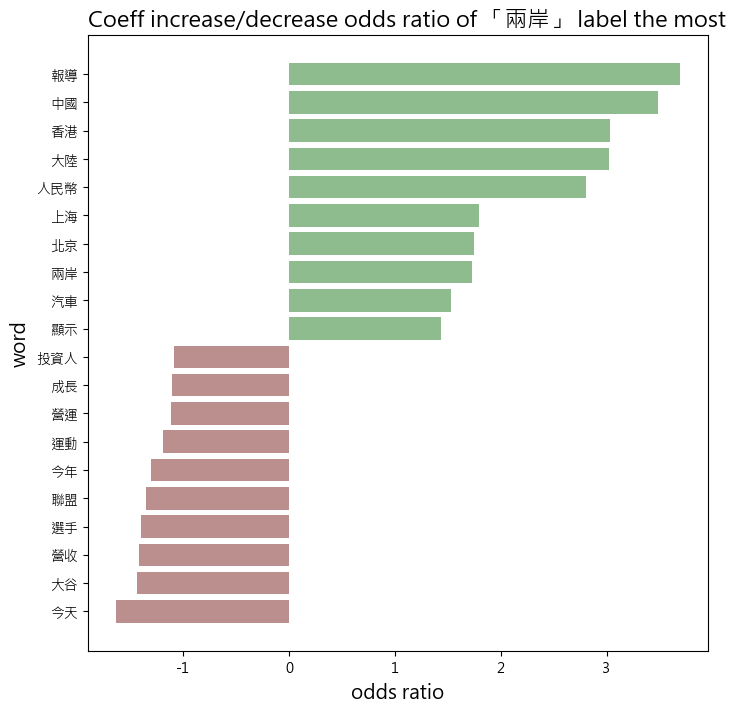

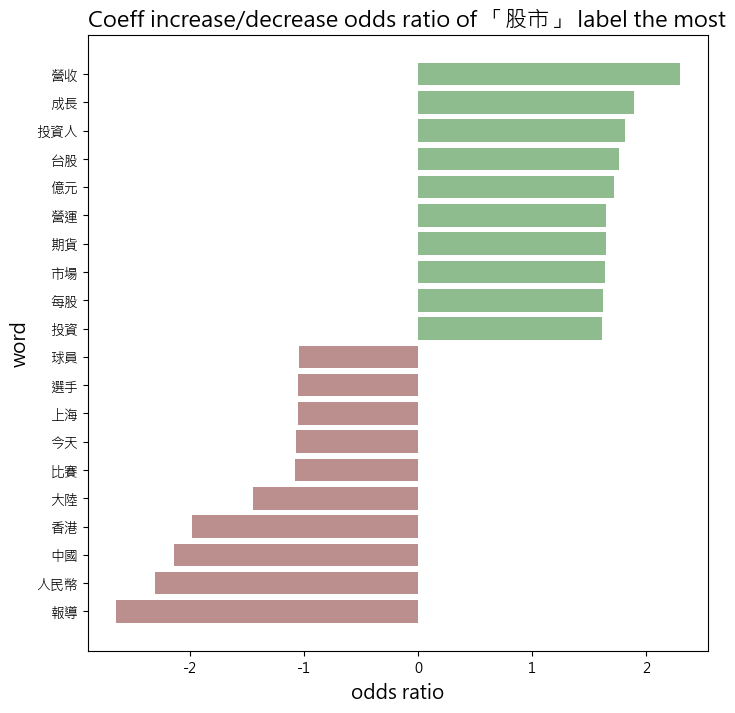

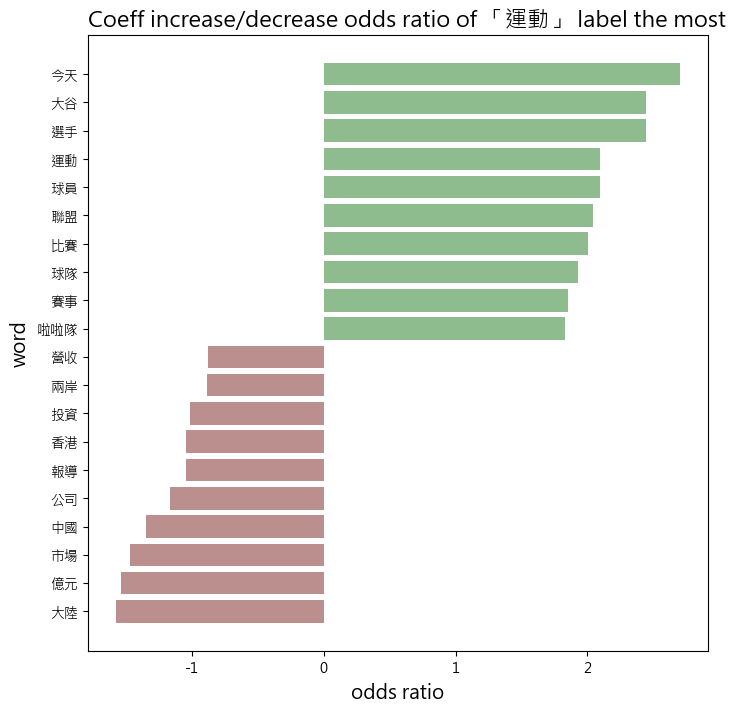

In [138]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「全球」中出現了川普、美國、英國等國際新聞關鍵字；「兩岸」中高係數的字是與中國有關的大陸、中國、人民幣；「股市」則是台股、期貨相關的字；「運動」是比賽、球員、聯盟相關字。

## 6. 預測新聞類別

`ebc_news_202403.csv` 為東森新聞網資料
- 版別：財經、國際、體育、（政治、兩岸）
- 時間範圍：2024/03/01 ~ 2024/03/30
- 工作流程平台搜尋/排除關鍵字：無

In [139]:
ct = pd.read_csv("./raw_data/group3_inference.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,MLB／大谷明出面說明水原涉賭案！事件爆發一周後將打破沉默,3/25/2024 8:05,運動,https://udn.com/news/story/11247/7853590,日本放送協會報導，道奇隊日本球星大谷翔平於美國時間24日表示，將在25日向外界說明前任專屬翻...,UDN
1,2,MLB／大谷翔平自行決定26日受訪談水原 道奇教頭盼真相大白,3/25/2024 9:06,運動,https://udn.com/news/story/11247/7853630,沉默數日，大谷翔平今天走進休息室向媒體預告，自己將在明天受訪首度談論前翻譯水原一平涉賭事件，...,UDN
2,3,MLB／水原一平紅襪資歷確定是假的 岡島秀樹發文證實,3/25/2024 12:37,運動,https://udn.com/news/story/11247/7854089,道奇隊日籍球星大谷翔平的前翻譯水原一平涉嫌簽賭，近日他的個人經歷被挖出，紅襪球團表示從未聘任...,UDN
3,4,MLB／水原涉賭 大谷今首度出面說明,3/26/2024 0:40,運動,https://udn.com/news/story/11247/7855692,道奇隊結束南韓首爾海外開幕戰，回到美國本土繼續進行熱身賽，昨對天使隊展開3連戰首戰，大谷翔平...,UDN
4,5,MLB／我從未簽賭！大谷還原時間軸 說明水原涉賭案,3/26/2024 6:46,運動,https://udn.com/news/story/11247/7855935,美國有線電視新聞網（CNN）報導，美國當地時間25日，職棒大聯盟MLB洛杉磯道奇球星大谷翔平...,UDN
...,...,...,...,...,...,...,...
2810,2811,奇葩設計！大陸這所學校「男廁設在女廁裡」 校方遭砲轟淡定回應,4/5/2024 15:01,兩岸,https://udn.com/news/story/7335/7879596,近日有學生發影片「抽水」大陸長春理工大學一廁所設計「真逆天」，男廁所竟是設在女廁所裡面，想進...,UDN
2811,2812,控前妻婚內出軌...綠帽男悲憤挖對方父母墳墓 遭告上法院下場曝光,4/5/2024 16:00,兩岸,https://udn.com/news/story/7335/7879615,一名大陸男子因情感問題，醉酒後挖掘前妻父母的墳墓，最終被法院判決支付前妻精神損害賠償。根據陸...,UDN
2812,2813,清明連假人潮湧入！山東趵突泉寸步難行 保全「驚恐抱柱」險落水,4/6/2024 9:25,兩岸,https://udn.com/news/story/7335/7880586,周四（4日）是中國清明假期的首日，各大景區迎來客流高峰。位於山東濟南的趵突泉景區，有一名保全...,UDN
2813,2814,太缺德！大樓住戶裝「探照燈」亮整天 強光直射他家超崩潰,4/6/2024 10:04,兩岸,https://udn.com/news/story/7335/7880590,已所不欲，物施於人，這樣擾鄰的行為真的好嗎？有香港黃大仙居民近日在網上發文，抱怨對面大樓的住...,UDN


In [140]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,MLB／大谷明出面說明水原涉賭案！事件爆發一周後將打破沉默日本放送協會報導，道奇隊日本球星大...,https://udn.com/news/story/11247/7853590,運動,MLB 大谷 出面 說明 水原 涉賭 事件 爆發 一周 後將 打破 沉默 日本 放送 協會 ...
1,MLB／大谷翔平自行決定26日受訪談水原 道奇教頭盼真相大白沉默數日，大谷翔平今天走進休息室...,https://udn.com/news/story/11247/7853630,運動,MLB 大谷 翔平 自行決定 26 日受 訪談 水原 道奇 教頭 真相大白 沉默 數日 大谷...
2,MLB／水原一平紅襪資歷確定是假的 岡島秀樹發文證實道奇隊日籍球星大谷翔平的前翻譯水原一平涉...,https://udn.com/news/story/11247/7854089,運動,MLB 水原 一平紅襪 資歷 確定 岡島 秀樹 發文 證實 道奇 日籍 球星 大谷 翔平 翻...
3,MLB／水原涉賭 大谷今首度出面說明道奇隊結束南韓首爾海外開幕戰，回到美國本土繼續進行熱身賽...,https://udn.com/news/story/11247/7855692,運動,MLB 水原 涉賭 大谷 首度 出面 說明 道奇 結束 南韓 首爾 海外 開幕 回到 美國 ...
4,MLB／我從未簽賭！大谷還原時間軸 說明水原涉賭案美國有線電視新聞網（CNN）報導，美國當地...,https://udn.com/news/story/11247/7855935,運動,MLB 簽賭 大谷 還原 時間軸 說明 水原 涉賭 美國有線電視新聞網 CNN 報導 美國 ...


In [141]:
ct['artCatagory'].value_counts()

artCatagory
股市    1059
兩岸     939
運動     817
Name: count, dtype: int64

In [142]:
mapper = {"股市":"股市", "兩岸":"兩岸", "運動":"運動"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.99      0.99       939
          股市       0.99      0.99      0.99      1059
          運動       0.99      0.99      0.99       817

    accuracy                           0.99      2815
   macro avg       0.99      0.99      0.99      2815
weighted avg       0.99      0.99      0.99      2815



In [143]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,MLB 大谷 出面 說明 水原 涉賭 事件 爆發 一周 後將 打破 沉默 日本 放送 協會 ...,運動,運動
1,MLB 大谷 翔平 自行決定 26 日受 訪談 水原 道奇 教頭 真相大白 沉默 數日 大谷...,運動,運動
2,MLB 水原 一平紅襪 資歷 確定 岡島 秀樹 發文 證實 道奇 日籍 球星 大谷 翔平 翻...,運動,運動
3,MLB 水原 涉賭 大谷 首度 出面 說明 道奇 結束 南韓 首爾 海外 開幕 回到 美國 ...,運動,運動
4,MLB 簽賭 大谷 還原 時間軸 說明 水原 涉賭 美國有線電視新聞網 CNN 報導 美國 ...,運動,運動
...,...,...,...
2810,奇葩 設計 大陸 這所 學校 男廁 設在 女廁 校方 轟淡定 回應 近日 學生 影片 抽水 ...,兩岸,兩岸
2811,前妻 婚內 出軌 綠帽 悲憤 對方 父母 墳墓 遭告 法院 下場 曝光 一名 大陸 男子 情...,兩岸,兩岸
2812,清明 連假 人潮 湧入 山東 趵突泉 寸步難行 保全 驚恐 抱柱 落水 周四 中國 清明 假...,兩岸,兩岸
2813,缺德 大樓住戶 探照燈 整天 強光 直射 他家 崩潰 物施 擾鄰 行為 真的 香港 黃大仙 ...,兩岸,兩岸


In [144]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
258,中職 兄弟 公布 談薪 凱文 遭扣 10 刷新 FA 降薪 紀錄 中信 兄弟 球季 開打 公...,運動,兩岸
675,籃球 Dcard 網友 爆料 林書豪 災民 貼文 隨後 移除 國旗 爭議 昨天早上 台灣 東...,運動,兩岸
696,廣角鏡 全中 運燃 聖火 傳遞 暌違 12 年北市 今年 月將 再度 舉辦 全中運 教育局 ...,運動,兩岸
780,足球 球衣 數字 酷似 納粹 黨衛軍 符號 德國隊 急換 字體 德國 足球 國家隊 新版 球...,運動,兩岸
781,足球 中國 足壇 貪腐 20 俱樂部 曝光 陸媒促 嚴懲 中國 足壇 反腐 系列 近日 宣判...,運動,兩岸
829,陸股 政策 加持 彈力 強在 中國 兩會 定調 政策 重點 發展 新質 生產力 市場 後續 ...,股市,兩岸
1115,大陸 官方 禁用 Intel AMD 處理器 關注 三台 題材股 英國 金融時報 FT 報導...,股市,兩岸
1121,轉投資 上海 芯列 中國 安全 可信 清單 威盛 漲停 中國 規範 黨政機關 公營企業 採購...,股市,兩岸
1122,大陸 官方 禁用 英特爾 微處理器 受惠 股飆 漲停 英國 金融時報 FT 報導 指出 北京...,股市,兩岸
1228,葉倫要 施壓 北京 補貼 太陽能 元晶 茂迪 盤中 不漲反跌 美國 財政部長 葉倫 27 批...,股市,兩岸


In [145]:
false_pred.loc[false_pred['artCatagory']=='股市', :].head(50)

,words,artCatagory,pred
829,陸股 政策 加持 彈力 強在 中國 兩會 定調 政策 重點 發展 新質 生產力 市場 後續 ...,股市,兩岸
1115,大陸 官方 禁用 Intel AMD 處理器 關注 三台 題材股 英國 金融時報 FT 報導...,股市,兩岸
1121,轉投資 上海 芯列 中國 安全 可信 清單 威盛 漲停 中國 規範 黨政機關 公營企業 採購...,股市,兩岸
1122,大陸 官方 禁用 英特爾 微處理器 受惠 股飆 漲停 英國 金融時報 FT 報導 指出 北京...,股市,兩岸
1228,葉倫要 施壓 北京 補貼 太陽能 元晶 茂迪 盤中 不漲反跌 美國 財政部長 葉倫 27 批...,股市,兩岸
1303,推動 公益 凱基 證券 十年 助偏 學童 英語 學習 凱基 證券 捐助 凱基 慈善 基金會 ...,股市,兩岸
1372,巴黎 奧運 下半年 登場 運動 概念股 業績 看旺 法國巴黎 奧運 將在 登場 一度 奧運 ...,股市,運動
1409,中國 A50 指數 挑戰 關鍵 反壓 位置 關注 銀行 業績 中國 A50 指數 最近 創下...,股市,兩岸
1450,陸鋼市 不妙 台廠 有壓 鋼價 慘跌 2002 專家 表示 大陸 鋼市 快速 下行 出現 產...,股市,兩岸
1611,聯電 處分 股權 聯電 2303 公告 子公司 芯片 製造 蘇州 股份 有限公司 公告 處分...,股市,兩岸


In [149]:
false_pred.loc[1372, :]

words          巴黎 奧運 下半年 登場 運動 概念股 業績 看旺 法國巴黎 奧運 將在 登場 一度 奧運 ...
artCatagory                                                   股市
pred                                                          運動
Name: 1372, dtype: object

In [151]:
pprint(false_pred['words'][1372])

('巴黎 奧運 下半年 登場 運動 概念股 業績 看旺 法國巴黎 奧運 將在 登場 一度 奧運 概念股 再次 成為 市場 題材 包括 觀賞 賽事 電視 螢幕 '
 '面板 運動員 機能性 運動服 運動鞋 材料 製造商 運動 品牌 運動 明星 周邊 商品 商機 成為 市場 關注 焦點 奧運 賽事 賽者 穿著 代言 品牌 '
 '運動鞋 運動服 帶動 耐吉 Nike 愛迪達 adidas 國際品牌 銷量 國內 運動鞋 代工廠 寶成 豐泰 鈺齊 KY 志強 KY 受惠 運動鞋 製造 '
 '大廠 寶成 為例 2012 英國倫敦 奧運 當年 每股 盈餘 3.47 2011 2.01 大幅 成長 72% 2016 巴西 奧運 當年 每股 盈餘 '
 '4.43 2015 3.24 成長 36% 2021 日本 東京 奧運 每股 盈餘 4.9 2020 1.64 大幅 成長 1.98 疫情 影響 因素 '
 '奧運 賽事 帶來 需求 商機 影響 相對 明顯 法人 指出 疫情 期間 保持 安全 社交 距離 帶動 電視 筆電 液晶 顯示器 需求 東京 奧運 電視 '
 '螢幕 觀賞 賽事 需求 升至 高峰 今年 舉行 巴黎 奧運 是否 一波 觀賞 賽事 需求 有待 觀察 面板 雙虎 友達 群創 於今 舉行 巴黎 奧運 '
 '歐洲盃 足球賽 寄予厚望 法人 說明會 公開場合 表達 期盼 透過 螢幕 觀賞 賽事 需求 促進 面板 銷量 紡織業 儒鴻 聚陽 兩大 成衣廠 國際 '
 '知名品牌 代工 成為 熱門 奧運 概念股 兆豐 國際 投顧 副總經理 黃國 表示 奧運 概念股 主要 大型 運動 賽事 帶動 消費 題材 搭配 國際 '
 '知名 運動 品牌 強大 國際 行銷 操作 代工廠 成為 投資 市場 關注 熱門 標的 華南 投顧 董事長 儲祥生 認為 人工智慧 AI 概念股 熱門 '
 '奧運 概念股 表現 變成 插曲 AI 概念股 休息 墊檔 成為 台股 主軸 儲祥生 指出 投資人 鎖定 奧運 概念股 電視 面板 運動鞋 製造 運動服 '
 '紡織廠 股價 位階 決定 是否 奧運 題材 有所 表現 重要 因素')


模型對另一個新聞網的預測結果比較普通。可以看到兩岸的 precision 與 recall 都相對低，從預測結果來看，可以發現東森新聞的「全球」類別，也常常會報導中國的資訊，因為出現中國、大陸等字樣，使模型預測成「兩岸」。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。